In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# 导入数据，查看前几列是否有问题
data = pd.read_csv("./data/2_preprcossing_train.csv", index_col='id')
data.head(5)

,age,info_rate,job_1,job_3,marital_out,education_1,education_2,education_3,default_out,housing_out,...,campaign,pdays,previous,poutcome_out,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,0.75,0,0,1,0,0,0,0,0,...,NaN,999.0,0.0,0,1.1,93.994,-36.4,4.857,5191.0,0.0
1,57.0,1.00,1,0,1,1,0,0,0,0,...,1.0,999.0,0.0,0,1.1,93.994,-36.4,4.857,5191.0,0.0
2,37.0,0.75,1,0,0,1,0,0,0,0,...,1.0,999.0,0.0,0,1.1,93.994,-36.4,4.857,5191.0,0.0
3,40.0,1.00,0,1,1,0,0,0,0,0,...,1.0,999.0,0.0,0,1.1,93.994,-36.4,4.857,5191.0,0.0
4,56.0,1.00,1,0,1,1,0,0,0,0,...,1.0,999.0,NaN,0,1.1,93.994,-36.4,4.857,5191.0,0.0


In [7]:
# X y 分离
X = data.iloc[:, :-1]
y = data['y']
y

id
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
41183    1.0
41184    0.0
41185    0.0
41186    1.0
41187    0.0
Name: y, Length: 41188, dtype: float64

In [8]:
# 训练测试分离。全局使用唯一的随机种子，避免模型不稳定
from sklearn.model_selection import train_test_split
random_seed = 42
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=random_seed, stratify=y)

In [9]:
# 使用均值填充训练集，并用此均值填充验证集
from sklearn.impute import SimpleImputer
# mean, median, most_frequent, constant(fill_value=), missing_values=-1
impute = SimpleImputer(strategy='mean')
X_train = impute.fit_transform(X_train)
X_valid = impute.transform(X_valid)
X_train = pd.DataFrame(X_train, columns=X.columns)


In [10]:
# 使用均值填充训练集，并用此均值填充验证集
from sklearn.impute import SimpleImputer
# mean, median, most_frequent, constant(fill_value=), missing_values=-1
impute = SimpleImputer(strategy='mean')
X_train = impute.fit_transform(X_train)
X_valid = impute.transform(X_valid)
X_train = pd.DataFrame(X_train, columns=X.columns)

D:\anaconda\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [11]:
# 如果正负样本失衡，使用imblearn上采样。
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
oversample = BorderlineSMOTE()
X_over, y_over = oversample.fit_resample(X_train, y_train)
y_over.value_counts()

0.0    27411
1.0    27411
Name: y, dtype: int64

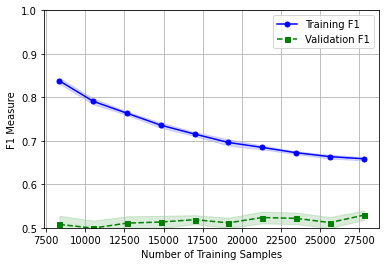

In [19]:
# 绘制偏差-方差曲线，判断样本量是否足够。
from sklearn.model_selection import learning_curve
from lightgbm.sklearn import LGBMClassifier
lgb = LGBMClassifier(random_state=random_seed)
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=lgb, X=X_train, y=y_train, scoring='f1',
                   train_sizes=np.linspace(0.3, 1.0, 10), cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training F1')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', linestyle='--', markersize=5, label='Validation F1')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Measure")
plt.legend(loc='upper right')
plt.ylim([0.5, 1.0])
plt.show()

In [20]:
# 定义绘制超参得分的曲线
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import validation_curve

def plot_validation_curve(train_scores, test_scores, param_range, xscale=None, ylim=[0.5, 1.0]):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training Score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(param_range, test_mean, color='green', marker='s', linestyle='--', markersize=5, label='Validation Score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.grid()
    if xscale is not None:
        plt.xscale(xscale)
    plt.xlabel("Parameter Range")
    plt.ylabel("F1 Measure")
    plt.legend(loc='lower right')
    plt.ylim(ylim)
    plt.show()

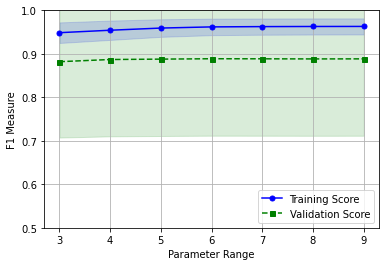

In [28]:
lgb = LGBMClassifier(random_state=random_seed, boosting_type='dart')
param_range = [3, 4, 5, 6, 7, 8, 9]
train_scores, test_scores = validation_curve(estimator=lgb,X=X_over, y=y_over,
                                             param_name='max_depth',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, param_range=param_range) # 注意None

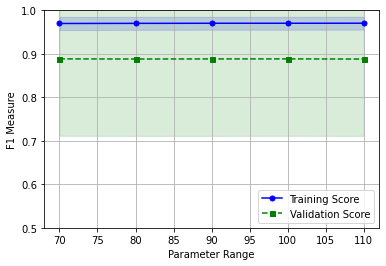

In [32]:
# 一个个调参，减少调参所需时间（虽然不一定能找到最好的超参）。
# 根据合适的得分，选择 num_leaves
lgb = LGBMClassifier(max_depth=7, random_state=random_seed, boosting_type='dart')
param_range = [70,80,90,100,110] # 4,5,6
train_scores, test_scores = validation_curve(estimator=lgb,X=X_over, y=y_over,
                                             param_name='num_leaves',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, param_range=param_range) # 注意None

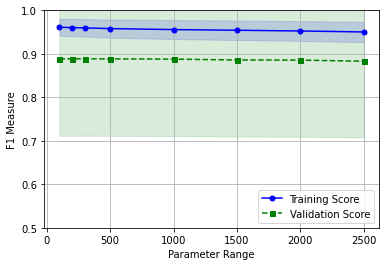

In [36]:
# 根据合适的得分，选择  min_child_samples
lgb = LGBMClassifier(num_leaves=100, max_depth=7, min_child_samples=None, random_state=random_seed, boosting_type='dart')
param_range = [100,200,300,500,1000,1500,2000,2500]
train_scores, test_scores = validation_curve(estimator=lgb,X=X_over, y=y_over,
                                             param_name=' min_child_samples',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, param_range=param_range) # 注意None

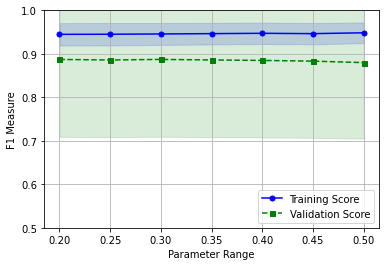

In [47]:
# 调整 feature_fraction
lgb = LGBMClassifier(num_leaves=100, max_depth=7, min_child_samples=500, random_state=random_seed, colsample_bytree=None, boosting_type='dart')
param_range = [0.2,0.25,0.3,0.35,0.4,0.45,0.5] # 4,5,6
train_scores, test_scores = validation_curve(estimator=lgb,X=X_over, y=y_over,
                                             param_name='feature_fraction',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, param_range=param_range) # 注意None

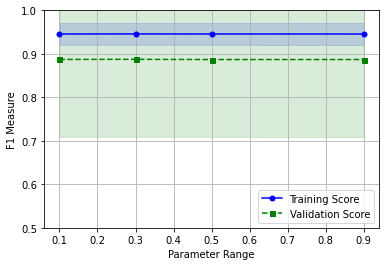

In [51]:
# 调整 feature_fraction
lgb = LGBMClassifier(min_split_gain=None, feature_fraction=0.3, num_leaves=100, max_depth=7, min_child_samples=500, random_state=random_seed, colsample_bytree=None, boosting_type='dart')
param_range = [0.1,0.3,0.5,0.9] # 4,5,6
train_scores, test_scores = validation_curve(estimator=lgb,X=X_over, y=y_over,
                                             param_name='min_split_gain',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, param_range=param_range) # 注意None

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] lambda_l1 is set=1000, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1000
[LightGBM] [Warning] lambda_l1 is set=10000, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10000
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignore

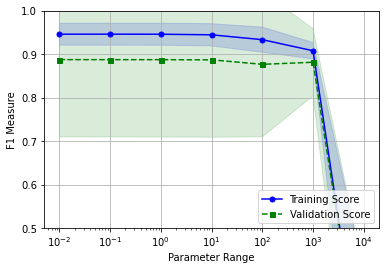

In [52]:
# 调整 lambda_l1
lgb = LGBMClassifier(reg_alpha=None, min_gain_to_split=None, feature_fraction=0.3, num_leaves=100, max_depth=7, min_child_samples=500, random_state=random_seed, colsample_bytree=None, boosting_type='dart')
param_range = [0.01,0.1,1,10,100,1000,10000] # 4,5,6
train_scores, test_scores = validation_curve(estimator=lgb,X=X_over, y=y_over,
                                             param_name='reg_alpha',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, xscale="log", param_range=param_range) # 注意None

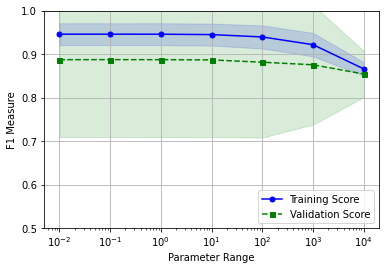

In [53]:
# 调整 lambda_l2
lgb = LGBMClassifier(reg_lambda=None, reg_alpha=None, min_gain_to_split=None, feature_fraction=0.3, num_leaves=100, max_depth=7, min_child_samples=500, random_state=random_seed, colsample_bytree=None, boosting_type='dart')
param_range = [0.01,0.1,1,10,100,1000,10000] # 4,5,6
train_scores, test_scores = validation_curve(estimator=lgb,X=X_over, y=y_over,
                                             param_name='reg_lambda',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, xscale="log", param_range=param_range) # 注意None

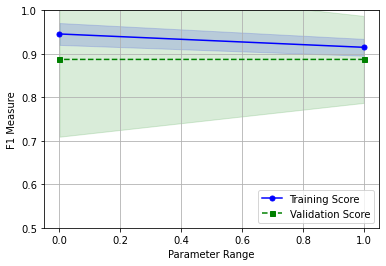

In [54]:
# 调整 extra_trees
lgb = LGBMClassifier(reg_lambda=None, reg_alpha=None, min_gain_to_split=None, feature_fraction=0.3, num_leaves=100, max_depth=7, min_child_samples=500, random_state=random_seed, colsample_bytree=None, boosting_type='dart')
param_range = [True, False] # 4,5,6
train_scores, test_scores = validation_curve(estimator=lgb,X=X_over, y=y_over,
                                             param_name='extra_trees',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, param_range=param_range) # 注意None

In [60]:
# 最终模型得分
from sklearn.metrics import f1_score
lgb = LGBMClassifier(max_depth=7, random_state=random_seed, colsample_bytree=None)
lgb.fit(X_over, y_over)

y_train_pred = lgb.predict(X_over)
y_valid_pred = lgb.predict(X_valid)

print(f1_score(y_over, y_train_pred))
print(f1_score(y_valid, y_valid_pred))

0.9586110853216973
0.5496722138174484


In [40]:
lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_samples': 500,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}